In [19]:
import hyrax
from pathlib import Path
import re
import toml
import matplotlib.pyplot as plt
import numpy as np

from hyrax.data_sets.inference_dataset import InferenceDataSet
import pandas as pd
import glob
import logging

In [20]:
def extract_exp_from_run(target_run_number):
    all_umap_list = sorted(glob.glob("results/*umap*"))
    
    for um in all_umap_list:
        run_number = toml.load(f"{um}/original_dataset_config.toml")["train"]["run_name"]

        if int(run_number.split("_")[1][-2:]) == target_run_number:
            print(run_number, um)

In [21]:
def extract_infer_from_run(target_run_number):
    import os
    all_umap_list = sorted(glob.glob("results/*infer*"))
    
    for um in all_umap_list:
        if os.path.exists(f"{um}/original_dataset_config.toml"):
            run_number = toml.load(f"{um}/original_dataset_config.toml")["train"]["run_name"]

            print(run_number, um)
            # if int(run_number.split("_")[1][-2:]) == target_run_number:
            #     print(run_number, um)

In [22]:
extract_exp_from_run(5)

run02_05 results/20250730-082844-umap-w3KP
run03_05 results/20250802-044306-umap-JCHT
run_05_01 results/20250810-233959-umap-JK4u
run_05_02 results/20250810-235420-umap-EBT_
run_05_03 results/20250811-000742-umap-GUNY
run_05_04 results/20250811-002125-umap-_9fe
run_05_05 results/20250811-003532-umap-qUrG
run_05_06 results/20250811-004924-umap-0Nhk
run_05_07 results/20250812-004824-umap-GUpo
run_05_08 results/20250812-005116-umap-AGmz
run_05_09 results/20250812-005410-umap-EDV4
run_05_10 results/20250812-005706-umap-9gA9
run_05_11 results/20250812-010000-umap-MQ08
run_05_12 results/20250812-010253-umap-oAjh
run_05_13 results/20250812-010549-umap-EUQk
run_05_11 results/20250812-013747-umap-jurQ
run_05_11 results/20250812-013759-umap-nbyl
run_05_11 results/20250812-013806-umap-g8Wz
run_05_11 results/20250812-013812-umap-_89N
run_05_11 results/20250812-013819-umap-xQky
run_05_11 results/20250812-013826-umap-t6B7
run_05_11 results/20250812-013833-umap-1zNP
run_05_11 results/20250813-050154-

In [23]:
def plot_umap_simple(ax, config=None, input_dir=None, alpha=0.6, s=1, color=None,
                       color_column=None, vmin=None, vmax=None, log_colorbar=False,
                       density=False, cmap='viridis', title=None, supress_hyrax_logs=False):
  """
  Create a simple static matplotlib scatter plot of 2D UMAP results on provided axis.
  
  Parameters
  ----------
  ax : matplotlib.axes.Axes
      The axis to plot on
  config: 
      Hyrax config object
  input_dir : str or Path, optional
      Directory containing UMAP results. If None, uses most recent in current results dir.
  alpha : float, default 0.6
      Point transparency
  s : float, default 1
      Point size
  color : array-like, optional
      Color values for scatter plot. If provided, overrides color_column.
  color_column : str, optional
      Name of catalog column to use for coloring points
  vmin : float, optional
      Minimum value for color scaling
  vmax : float, optional
      Maximum value for color scaling
  log_colorbar : bool, default False
      If True, use logarithmic color scaling
  density : bool, default False
      If True, plot hexbin density plot instead of scatter
  cmap : str, default 'viridis'
      Colormap name
  title : str, default None
      Plot title
      
  Returns
  -------
  matplotlib.axes.Axes
      The axis object with the plot
  """

  from hyrax.data_sets.inference_dataset import InferenceDataSet
  from matplotlib.colors import LogNorm, Normalize
      
  # Load UMAP results
  umap_results = plot_one_umap(input_dir)
    
  # Extract 2D coordinates
  points = np.array([point.numpy() for point in umap_results])
  x, y = points[:, 0], points[:, 1]

  # Handle color specification
  color_values = None
  colorbar_label = None

  if color is not None:
      # Use provided color array (original behavior)
      color_values = color
      colorbar_label = 'Point Index'
  elif color_column is not None:
      # Get color values from catalog column
      try:
          # Get all available fields to check if column exists
          available_fields = umap_results.metadata_fields()
          if color_column not in available_fields:
              raise ValueError(f"Column '{color_column}' not found in dataset. Available fields: {available_fields}")

          # Get all indices for the dataset
          all_indices = list(range(len(umap_results)))

          # Extract metadata for the specified column
          metadata = umap_results.metadata(all_indices, [color_column])
          color_values = np.array(metadata[color_column])
          colorbar_label = color_column

      except Exception as e:
          print(f"Warning: Could not load column '{color_column}': {e}")
          print("Proceeding without coloring")

  if density:
    # Create hexbin plot
    if color_values is not None:
        # Hexbin with color values - compute mean/median of color values in each bin
        # Determine normalization for color values
        if log_colorbar:
            # Ensure positive values for log scaling
            if np.any(color_values <= 0):
                min_positive = np.min(color_values[color_values > 0]) if np.any(color_values > 0) else 1e-10
                color_values = np.maximum(color_values, min_positive)
                print(f"Warning: Non-positive values found, clamped to {min_positive} for log scaling")

            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = Normalize(vmin=vmin, vmax=vmax)

        # Use reduce_C_function to aggregate color values in each hexbin
        hb = ax.hexbin(x, y, C=color_values, gridsize=50, cmap=cmap, norm=norm, reduce_C_function=np.mean)
        cbar = plt.colorbar(hb, ax=ax, label=colorbar_label)

        if log_colorbar:
            cbar.set_label(f'{colorbar_label} (log scale)')
    else:
        # Hexbin with just point density (counts)
        norm = LogNorm() if log_colorbar else None
        hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, norm=norm)
        plt.colorbar(hb, ax=ax, label='Count')
  else:
    # Regular scatter plot
    if color_values is not None:
        # Determine normalization
        if log_colorbar:
            # Ensure positive values for log scaling
            if np.any(color_values <= 0):
                min_positive = np.min(color_values[color_values > 0]) if np.any(color_values > 0) else 1e-10
                color_values = np.maximum(color_values, min_positive)
                print(f"Warning: Non-positive values found, clamped to {min_positive} for log scaling")

            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = Normalize(vmin=vmin, vmax=vmax)

        scatter = ax.scatter(x, y, alpha=alpha, s=s, c=color_values, cmap=cmap, norm=norm)
        cbar = plt.colorbar(scatter, ax=ax, label=colorbar_label)
    else:
        scatter = ax.scatter(x, y, alpha=alpha, s=s)


  # Styling
  if title is not None:
      ax.set_title(title)

  return ax

def plot_one_umap(umap_name):
    """Manually plot one umap"""
    umap_dir = f"results/{umap_name}/"

    original_config_filepath = glob.glob(f"{umap_dir}/origin*")

    logging.disable(logging.CRITICAL)
    umap_results = InferenceDataSet(original_config_filepath, results_dir=umap_dir, verb="umap")
    logging.disable(logging.NOTSET)

    return umap_results
    # h = hyrax.Hyrax(config_file=original_config_filepath)

    # h.config["results"]["inference_dir"] = umap_dir
    # h.prepare()

    # return original_config_filepath

In [24]:
exp_df = pd.read_csv("exp_list_run_05.csv")

exp_df

# umap_test = plot_one_umap(exp_df.loc[1, "umap_filename"])

,exp_name,umap_filename
0,run_05_01,20250810-233959-umap-JK4u
1,run_05_02,20250810-235420-umap-EBT_
2,run_05_03,20250811-000742-umap-GUNY
3,run_05_04,20250811-002125-umap-_9fe
4,run_05_05,20250811-003532-umap-qUrG
5,run_05_06,20250811-004924-umap-0Nhk
6,run_05_07,20250812-004824-umap-GUpo
7,run_05_08,20250812-005116-umap-AGmz
8,run_05_09,20250812-005410-umap-EDV4
9,run_05_10,20250812-005706-umap-9gA9


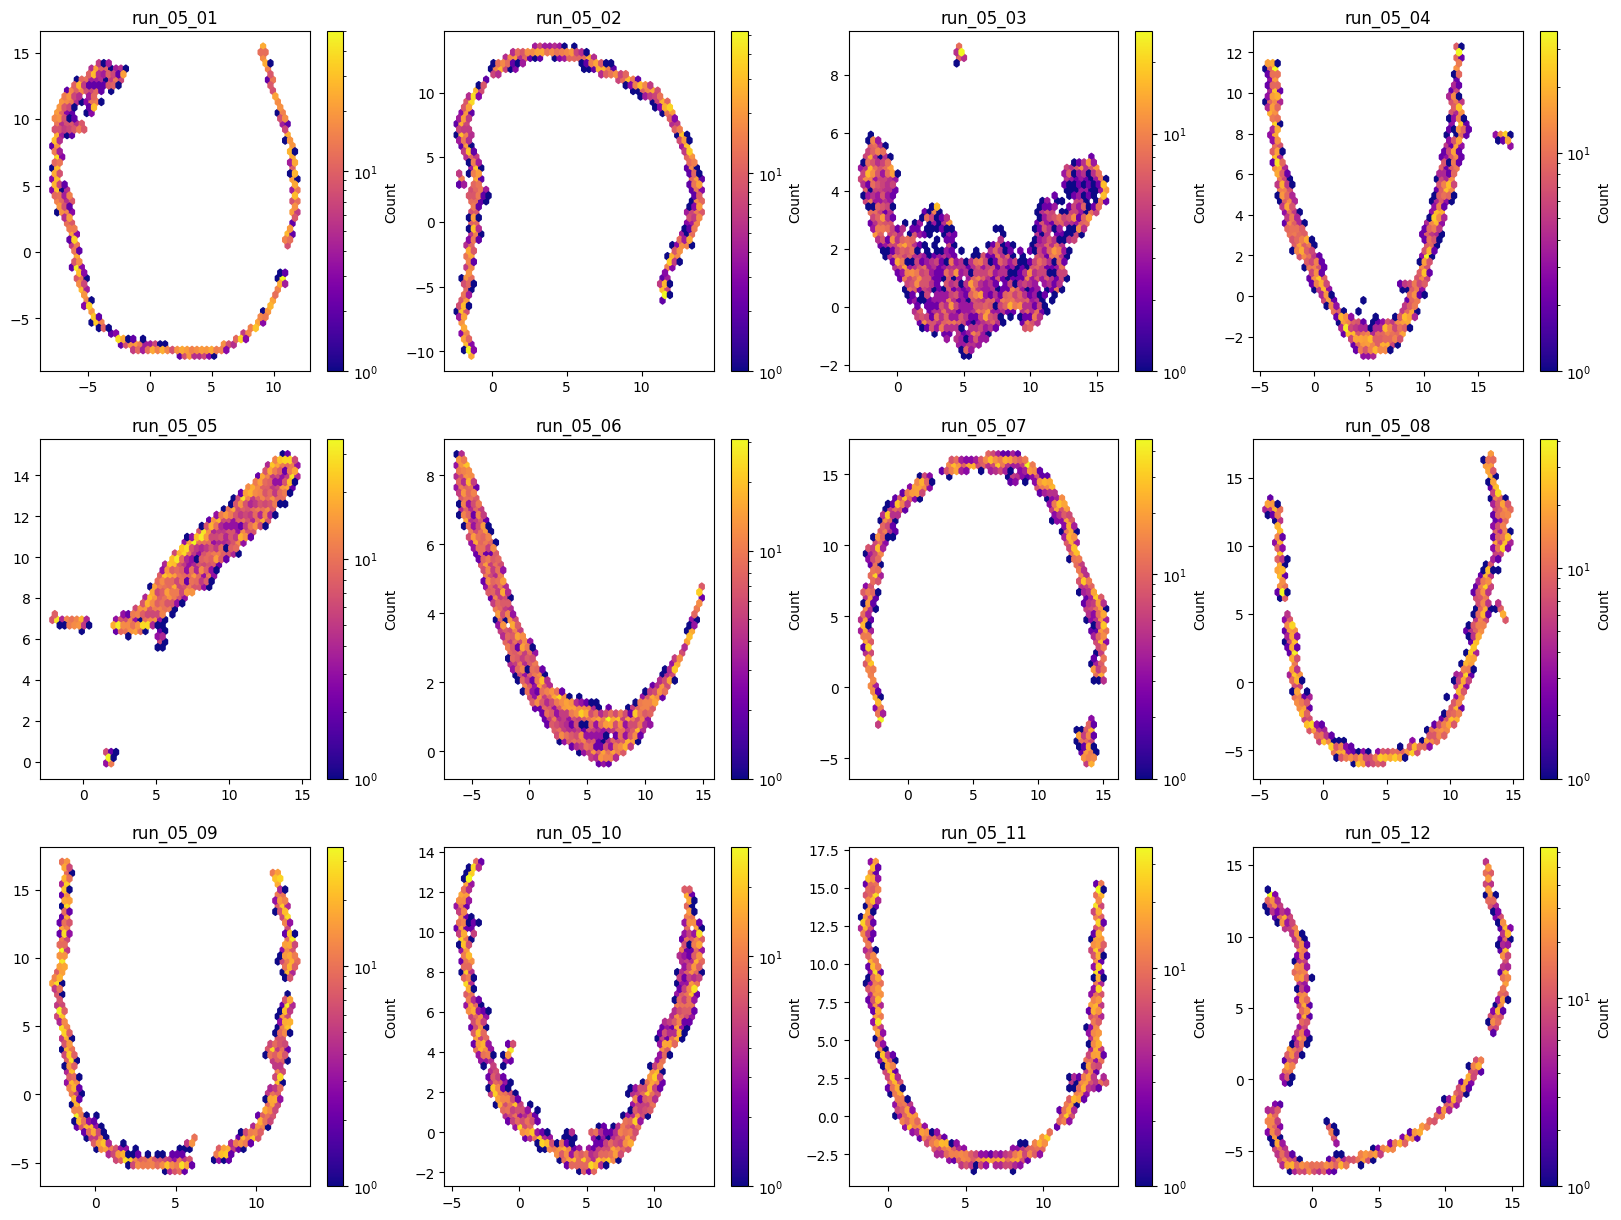

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, ax in enumerate(axes.flatten()):
    plot_umap_simple(ax, config=None, input_dir=exp_df.loc[i, "umap_filename"], alpha=0.8, s=1, cmap='plasma', density=True,
                     supress_hyrax_logs=False, log_colorbar=True, title=exp_df.loc[i, "exp_name"])
    

In [8]:
extract_infer_from_run(5)

run01_01 results/20250729-040425-infer-Bu0T
run01_01 results/20250729-042016-infer-Agcw
run01_01 results/20250729-043711-infer-vIj7
run01_01 results/20250729-045332-infer-Yqs1
run01_01 results/20250729-050920-infer-IvmP
run01_01 results/20250729-052418-infer-dFkU
run02_01 results/20250730-081219-infer-3KSc
run02_02 results/20250730-081558-infer-tr3o
run02_03 results/20250730-081958-infer-5m1Z
run02_04 results/20250730-082352-infer-rf3E
run02_05 results/20250730-082750-infer-CABs
run02_06 results/20250730-083146-infer-Xqnb
run02_07 results/20250730-091952-infer-VpDW
run02_08 results/20250730-092554-infer-LDgX
run02_09 results/20250730-093413-infer-UuzF
run02_09 results/20250730-094355-infer-7frt
run02_11 results/20250730-095448-infer-jWkk
run02_12 results/20250730-100108-infer-B55D
run03_01 results/20250802-034547-infer-iF5o
run03_02 results/20250802-035944-infer-EJqe
run03_03 results/20250802-041354-infer-UmyF
run03_04 results/20250802-042754-infer-Zgsg
run03_05 results/20250802-044152

# Running UMAP

In [9]:
neighbors_cands = [10, 15, 20, 25, 30, 60, 90]

for i, nb in enumerate(neighbors_cands):
    # UMAP investigate

    config_path = f"configs/run_05_03.toml"
    
    h = hyrax.Hyrax(config_file=config_path)
    
    h.config["results"]["inference_dir"] = "results/20250811-000630-infer-0FF0"
    h.config["umap.UMAP"]["n_components"] = 2
    h.config["umap.UMAP"]["n_neighbors"] = nb
    print(f"Using n_neighbors = {nb}")
    
    umap_res = h.umap()

Cannot find default_config.toml for torch.
[2025-08-14 21:11:20,047 hyrax:INFO] Runtime Config read from: configs/run_05_03.toml


Using n_neighbors = 10


[2025-08-14 21:12:05,676 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:05,892 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:07,280 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:07,280 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:07,280 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:07,347 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:17,801 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:17,839 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:17,851 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:18,021 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:18,022 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:18,022 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:18,088 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 15


[2025-08-14 21:12:19,649 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:19,649 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:19,649 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:19,715 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:20,102 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:20,660 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:24,683 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:24,722 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:24,734 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:24,904 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:24,904 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:24,905 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:24,971 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 20


[2025-08-14 21:12:26,210 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:26,211 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:26,211 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:26,278 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:26,670 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:27,216 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:31,344 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:31,385 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:31,397 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:31,566 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:31,567 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:31,567 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:31,635 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 25


[2025-08-14 21:12:32,892 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:32,892 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:32,892 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:32,960 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:33,344 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:33,901 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:38,074 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:38,115 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:38,127 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:38,297 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:38,298 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:38,298 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:38,367 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 30


[2025-08-14 21:12:39,632 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:39,632 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:39,633 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:39,701 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:40,098 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:40,659 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:44,892 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:44,932 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:44,943 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:45,113 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:45,113 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:45,113 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:45,182 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 60


[2025-08-14 21:12:46,430 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:46,431 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:46,431 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:46,499 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:46,891 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:47,442 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:51,734 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:51,775 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:51,786 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:51,956 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:51,956 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:51,957 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:52,027 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 90


[2025-08-14 21:12:53,278 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:53,278 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:53,279 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:53,348 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:12:53,744 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:12:54,295 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:12:58,682 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:12:58,723 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:12:58,734 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:12:58,904 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:12:58,904 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:12:58,905 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:12:58,975 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

In [25]:
exp_neighbors_df = pd.read_csv("exp_umap_run_05_03_01.csv")
exp_neighbors_df

,n_neighbors,umap_filepath
0,2,20250814-211832-umap-pjFA
1,3,20250814-211759-umap-T7ha
2,5,20250814-211742-umap-M40u
3,8,20250814-211726-umap-XCWT
4,10,20250814-211208-umap-02bC
5,12,20250814-211713-umap-xXEb
6,15,20250814-211220-umap-AAoH
7,20,20250814-211227-umap-Q6dQ
8,25,20250814-211233-umap-sEab
9,30,20250814-211240-umap-nJZX


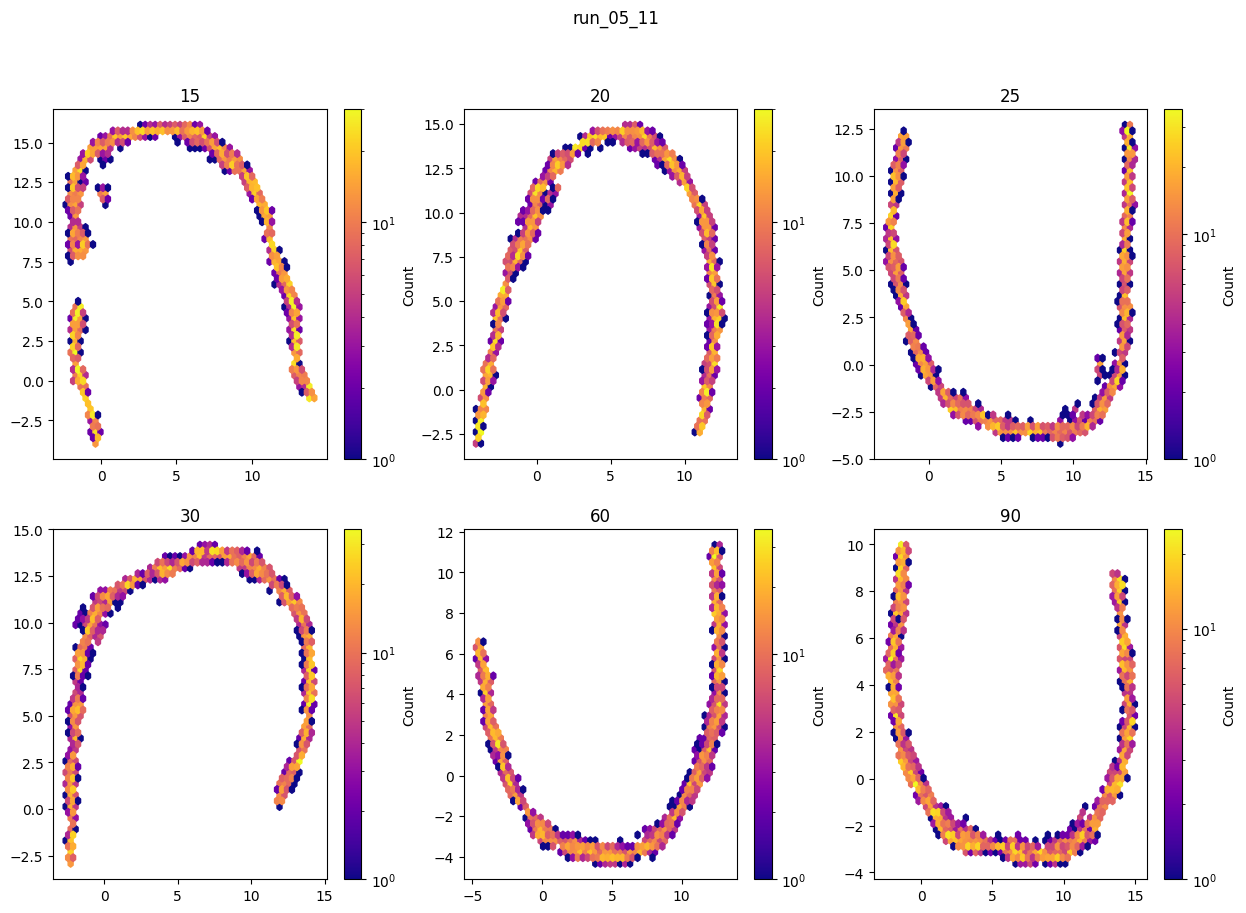

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

fig.suptitle("run_05_11")

for i, ax in enumerate(axes.flatten()):
    plot_umap_simple(ax, config=None, input_dir=exp_neighbors_df.loc[i, "umap_filepath"], alpha=0.8, s=1, cmap='plasma', density=True,
                 supress_hyrax_logs=False, log_colorbar=True, title=exp_neighbors_df.loc[i, "n_neighbors"])

In [22]:
# Interactive Visualization

[2025-08-13 04:52:01,007 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-08-13 04:52:01,069 hyrax:INFO] Runtime Config read from: configs/run_05_03.toml
[2025-08-13 04:52:01,071 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-13 04:52:01,093 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-13 04:52:02,372 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-13 04:52:02,373 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-13 04:52:02,373 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-13 04:52:02,438 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (339

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
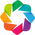

Row
    [0] HoloViews(DynamicMap, height=550, sizing_mode='fixed', width=550)
    [1] Column
        [0] HoloViews(DynamicMap, height=165, width=550)
        [1] HoloViews(DynamicMap)
        [2] Row
            [0] Button(button_type='primary', name='Resample Images')
            [1] LoadingSpinner(height=30, margin=(5, 10, 5, 0), width=30)

Row
    [0] HoloViews(DynamicMap, height=550, sizing_mode='fixed', width=550)
    [1] Column
        [0] HoloViews(DynamicMap, height=165, width=550)
        [1] HoloViews(DynamicMap)
        [2] Row
            [0] Button(button_type='primary', name='Resample Images')
            [1] LoadingSpinner(height=30, margin=(5, 10, 5, 0), width=30)

In [26]:
h = hyrax.Hyrax(config_file="configs/run_05_03.toml")

h.config["results"]["inference_dir"] = "results/20250811-000742-umap-GUNY"
h.prepare()

h.config["visualize"]["display_images"] = True
h.config["visualize"]["fields"] = ["coord_ra", "coord_dec"]
viz = h.visualize(width=550, height=550)
display(viz)

# UMAP `n_neighbors` < 15

In [10]:
neighbors_cands = [12, 10, 8, 5, 3, 2]

for i, nb in enumerate(neighbors_cands):
    # UMAP investigate

    config_path = f"configs/run_05_03.toml"
    
    h = hyrax.Hyrax(config_file=config_path)
    
    h.config["results"]["inference_dir"] = "results/20250811-000630-infer-0FF0"
    h.config["umap.UMAP"]["n_components"] = 2
    h.config["umap.UMAP"]["n_neighbors"] = nb
    print(f"Using n_neighbors = {nb}")
    
    umap_res = h.umap()

[2025-08-14 21:17:12,255 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-08-14 21:17:12,260 hyrax:INFO] Runtime Config read from: configs/run_05_03.toml
[2025-08-14 21:17:12,295 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:17:12,308 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits


Using n_neighbors = 12


[2025-08-14 21:17:12,477 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:12,477 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:12,477 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:12,546 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:17:12,935 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:17:13,487 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:17:17,540 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:17:17,581 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:17:17,593 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:17:17,761 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:17,762 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:17,762 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:17,832 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 10


[2025-08-14 21:17:19,070 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:19,071 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:19,071 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:19,141 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:17:19,523 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:17:20,068 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:17:24,120 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:17:24,163 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:17:24,174 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:17:24,345 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:24,345 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:24,346 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:24,418 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 8


[2025-08-14 21:17:25,663 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:25,663 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:25,663 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:25,734 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:17:26,126 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:17:26,682 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:17:39,385 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:17:39,427 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:17:39,439 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:17:39,610 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:39,611 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:39,611 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:39,682 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 5


[2025-08-14 21:17:40,941 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:40,941 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:40,941 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:41,012 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:17:41,406 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:17:41,959 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:17:56,743 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:17:56,783 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:17:56,795 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:17:56,964 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:56,965 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:56,965 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:57,038 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 3


[2025-08-14 21:17:58,307 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:17:58,308 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:17:58,308 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:17:58,382 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:17:58,778 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:17:59,332 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:18:29,597 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:18:29,641 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:18:29,653 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:18:29,826 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:18:29,826 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:18:29,826 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:18:29,900 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using n_neighbors = 2


[2025-08-14 21:18:31,155 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:18:31,156 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:18:31,156 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:18:31,227 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-14 21:18:31,619 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-14 21:18:32,175 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-14 21:19:02,048 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-14 21:19:02,091 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-14 21:19:02,102 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-14 21:19:02,271 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-14 21:19:02,272 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-14 21:19:02,272 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-14 21:19:02,347 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

In [11]:
sorted(glob.glob("results/*umap*"))

['results/20250729-040447-umap-MjKo',
 'results/20250729-042135-umap-Oj4C',
 'results/20250729-043830-umap-jfZ3',
 'results/20250729-045451-umap-nd_q',
 'results/20250729-051034-umap-JtD0',
 'results/20250729-052532-umap-9ROg',
 'results/20250730-081245-umap-FWw_',
 'results/20250730-081650-umap-KRvt',
 'results/20250730-082053-umap-Z16h',
 'results/20250730-082447-umap-li20',
 'results/20250730-082844-umap-w3KP',
 'results/20250730-083241-umap-dqoc',
 'results/20250730-092017-umap-q-K7',
 'results/20250730-092619-umap-IiRF',
 'results/20250730-093433-umap-ZFuU',
 'results/20250730-094419-umap-vSAq',
 'results/20250730-095509-umap-jv_i',
 'results/20250730-100128-umap-qvLo',
 'results/20250802-034641-umap-1Rod',
 'results/20250802-040058-umap-PnG0',
 'results/20250802-041508-umap-fAx2',
 'results/20250802-042907-umap-AYZ3',
 'results/20250802-044306-umap-JCHT',
 'results/20250802-045700-umap-LlF6',
 'results/20250802-210821-umap-EJfY',
 'results/20250802-213151-umap-zefK',
 'results/20

In [27]:
exp_neighbors_df = pd.read_csv("exp_umap_run_05_03_01.csv")
exp_neighbors_df

,n_neighbors,umap_filepath
0,2,20250814-211832-umap-pjFA
1,3,20250814-211759-umap-T7ha
2,5,20250814-211742-umap-M40u
3,8,20250814-211726-umap-XCWT
4,10,20250814-211208-umap-02bC
5,12,20250814-211713-umap-xXEb
6,15,20250814-211220-umap-AAoH
7,20,20250814-211227-umap-Q6dQ
8,25,20250814-211233-umap-sEab
9,30,20250814-211240-umap-nJZX


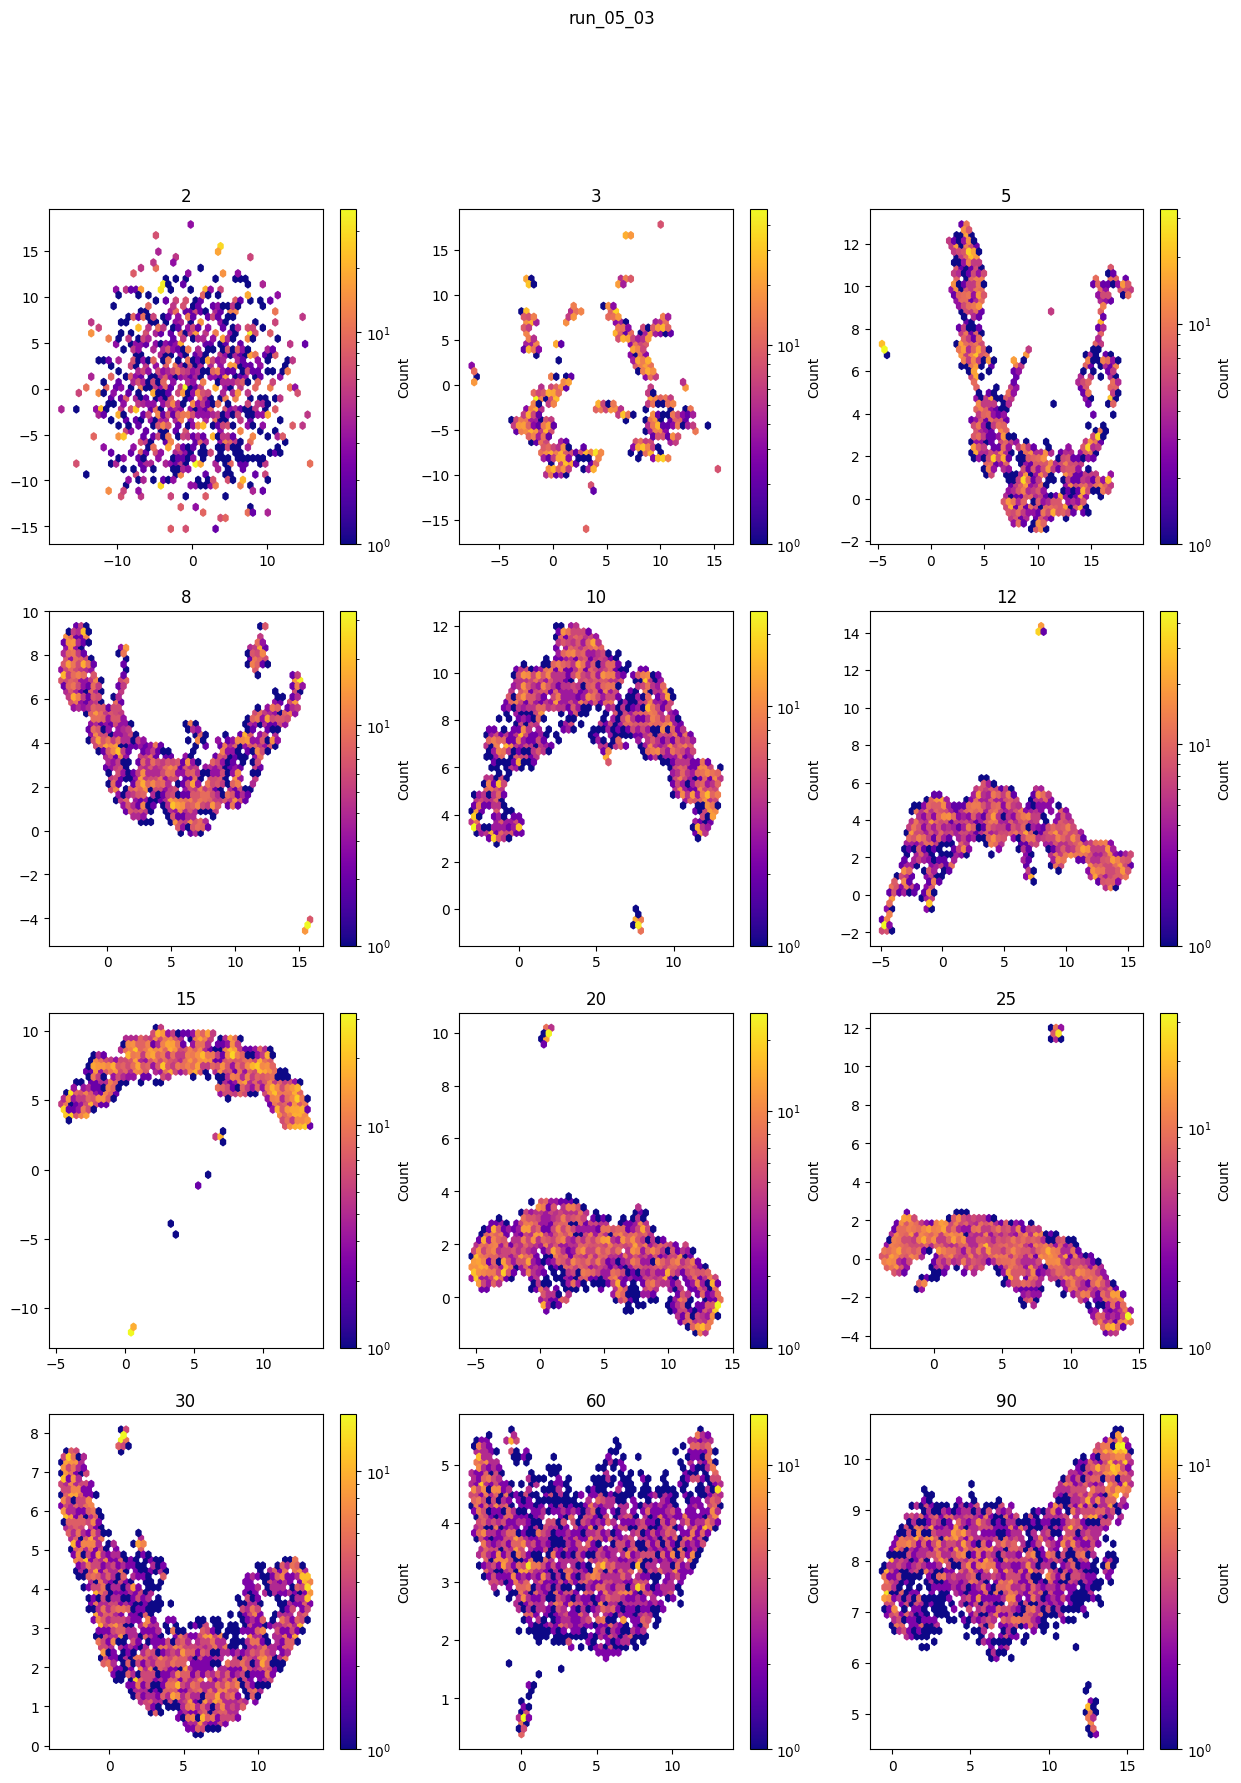

In [28]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

fig.suptitle("run_05_03")

for i, ax in enumerate(axes.flatten()):
    plot_umap_simple(ax, config=None, input_dir=exp_neighbors_df.loc[i, "umap_filepath"], alpha=0.8, s=1, cmap='plasma', density=True,
                 supress_hyrax_logs=False, log_colorbar=True, title=exp_neighbors_df.loc[i, "n_neighbors"])

fig.savefig("figures/run_05_neighbors_3.png")
    

In [33]:
# UMAP min_dist

In [15]:
min_dist_cands = [0.01, 0.1, 0.25, 0.5, 0.8, 0.99]

for i, md in enumerate(min_dist_cands):
    # UMAP investigate

    config_path = f"configs/run_05_03.toml"
    
    h = hyrax.Hyrax(config_file=config_path)
    
    h.config["results"]["inference_dir"] = "results/20250811-000630-infer-0FF0"
    h.config["umap.UMAP"]["n_components"] = 2
    h.config["umap.UMAP"]["n_neighbors"] = 8
    h.config["umap.UMAP"]["min_dist"] = md
    print(f"Using min_dist = {md}")
    
    umap_res = h.umap()

[2025-08-15 00:36:43,000 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-08-15 00:36:44,231 hyrax:INFO] Runtime Config read from: configs/run_05_03.toml


Using min_dist = 0.01


[2025-08-15 00:36:44,666 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:36:44,948 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:36:47,405 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:36:47,405 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:36:47,405 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:36:47,472 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:37:19,577 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:37:19,617 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:37:19,628 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:37:19,796 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:37:19,796 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:37:19,797 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:37:19,863 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using min_dist = 0.1


[2025-08-15 00:37:21,106 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:37:21,107 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:37:21,107 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:37:21,174 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15 00:37:21,566 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-15 00:37:22,120 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:37:53,360 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:37:53,402 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:37:53,413 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:37:53,579 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:37:53,580 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:37:53,580 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:37:53,649 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using min_dist = 0.25


[2025-08-15 00:37:54,876 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:37:54,877 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:37:54,877 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:37:54,943 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15 00:37:55,320 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-15 00:37:55,870 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:38:26,882 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:38:26,923 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:38:26,934 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:38:27,100 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:38:27,100 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:38:27,101 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:38:27,168 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using min_dist = 0.5


[2025-08-15 00:38:28,435 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:38:28,436 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:38:28,436 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:38:28,503 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15 00:38:28,901 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-15 00:38:29,447 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:38:59,823 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:38:59,867 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:38:59,883 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:39:00,060 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:39:00,060 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:39:00,060 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:39:00,129 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using min_dist = 0.8


[2025-08-15 00:39:01,359 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:39:01,359 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:39:01,359 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:39:01,425 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15 00:39:01,814 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-15 00:39:02,365 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:39:33,776 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:39:33,826 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:39:33,838 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:39:34,011 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:39:34,012 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:39:34,012 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:39:34,085 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

Using min_dist = 0.99


[2025-08-15 00:39:35,325 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:39:35,326 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:39:35,326 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:39:35,394 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-08-15 00:39:35,781 hyrax.data_sets.downloaded_lsst_dataset:INFO] Manifest merge completed: 494820 preserved, 0 added
[2025-08-15 00:39:36,320 hyrax.data_sets.downloaded_lsst_dataset:ERROR] Failed to save manifest: [Errno 13] Permission denied: '/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public

Creating lower dimensional representation using UMAP::   0%|          | 0/27 [00:00<?, ?it/s]

[2025-08-15 00:40:07,222 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-08-15 00:40:07,266 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-15 00:40:07,278 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-15 00:40:07,447 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-15 00:40:07,447 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-15 00:40:07,447 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-15 00:40:07,515 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). U

In [16]:
sorted(glob.glob("results/*umap*"))

['results/20250729-040447-umap-MjKo',
 'results/20250729-042135-umap-Oj4C',
 'results/20250729-043830-umap-jfZ3',
 'results/20250729-045451-umap-nd_q',
 'results/20250729-051034-umap-JtD0',
 'results/20250729-052532-umap-9ROg',
 'results/20250730-081245-umap-FWw_',
 'results/20250730-081650-umap-KRvt',
 'results/20250730-082053-umap-Z16h',
 'results/20250730-082447-umap-li20',
 'results/20250730-082844-umap-w3KP',
 'results/20250730-083241-umap-dqoc',
 'results/20250730-092017-umap-q-K7',
 'results/20250730-092619-umap-IiRF',
 'results/20250730-093433-umap-ZFuU',
 'results/20250730-094419-umap-vSAq',
 'results/20250730-095509-umap-jv_i',
 'results/20250730-100128-umap-qvLo',
 'results/20250802-034641-umap-1Rod',
 'results/20250802-040058-umap-PnG0',
 'results/20250802-041508-umap-fAx2',
 'results/20250802-042907-umap-AYZ3',
 'results/20250802-044306-umap-JCHT',
 'results/20250802-045700-umap-LlF6',
 'results/20250802-210821-umap-EJfY',
 'results/20250802-213151-umap-zefK',
 'results/20

In [29]:
exp_neighbors_df = pd.read_csv("exp_umap_run_05_03_02.csv")
exp_neighbors_df

,min_dist,umap_filepath
0,0.01,20250815-003648-umap-wHNt
1,0.10,20250815-003722-umap-v3Yu
2,0.25,20250815-003755-umap-_LlV
3,0.50,20250815-003829-umap-57wg
4,0.80,20250815-003902-umap-JhXY
5,0.99,20250815-003936-umap-fm26


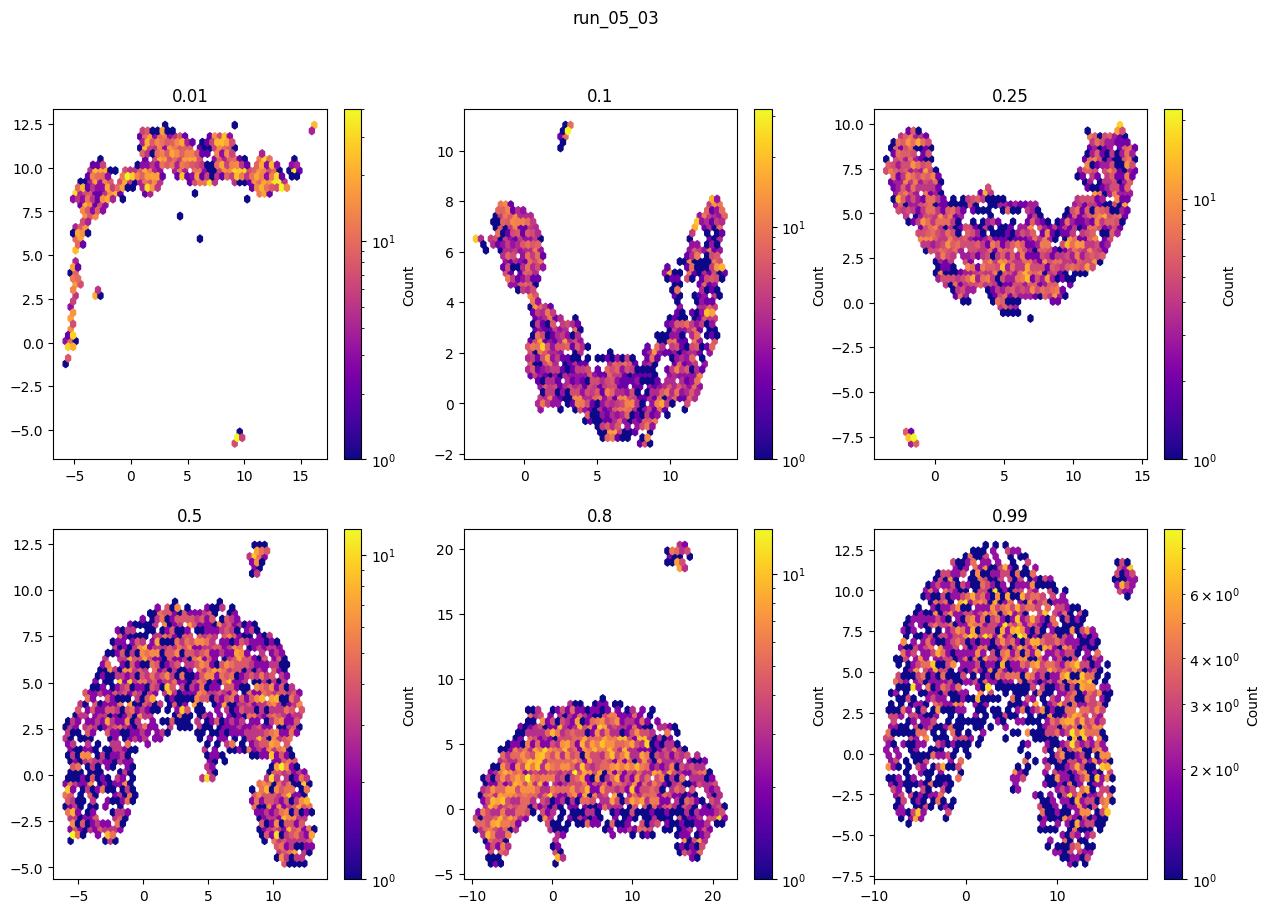

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

fig.suptitle("run_05_03")

for i, ax in enumerate(axes.flatten()):
    plot_umap_simple(ax, config=None, input_dir=exp_neighbors_df.loc[i, "umap_filepath"], alpha=0.8, s=1, cmap='plasma', density=True,
                 supress_hyrax_logs=False, log_colorbar=True, title=exp_neighbors_df.loc[i, "min_dist"])

fig.savefig("figures/run_05_mindist_2.png")
    

[2025-08-13 05:29:10,187 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-08-13 05:29:10,265 hyrax:INFO] Runtime Config read from: configs/run_05_11.toml
[2025-08-13 05:29:10,268 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-08-13 05:29:10,290 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-08-13 05:29:11,565 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-08-13 05:29:11,566 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-08-13 05:29:11,566 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-08-13 05:29:11,635 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (339

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
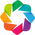

Row
    [0] HoloViews(DynamicMap, height=550, sizing_mode='fixed', width=550)
    [1] Column
        [0] HoloViews(DynamicMap, height=165, width=550)
        [1] HoloViews(DynamicMap)
        [2] Row
            [0] Button(button_type='primary', name='Resample Images')
            [1] LoadingSpinner(height=30, margin=(5, 10, 5, 0), width=30)

Row
    [0] HoloViews(DynamicMap, height=550, sizing_mode='fixed', width=550)
    [1] Column
        [0] HoloViews(DynamicMap, height=165, width=550)
        [1] HoloViews(DynamicMap)
        [2] Row
            [0] Button(button_type='primary', name='Resample Images')
            [1] LoadingSpinner(height=30, margin=(5, 10, 5, 0), width=30)

In [39]:
h = hyrax.Hyrax(config_file="configs/run_05_11.toml")

h.config["results"]["inference_dir"] = "results/20250813-051952-umap-VhgD"
h.prepare()

h.config["visualize"]["display_images"] = True
h.config["visualize"]["fields"] = ["coord_ra", "coord_dec"]
viz = h.visualize(width=550, height=550)
display(viz)